<a href="https://colab.research.google.com/github/Lucas-Siade/Data-Science/blob/main/Codes/N%C3%A3o%20Supervisionado/DS%20-%20Gaussian%20Mixture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exemplo**

## **Bibliotecas**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

## **Dataset**

In [34]:
datasetGaussMix = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Science/Dataset - Iris.csv")

#DEFINIÇÃO DAS COLUNAS
datasetGaussMix.drop(['Id'], axis=1, inplace=True)

datasetGaussMix.rename(columns={
    'SepalLengthCm': 'Comprimento da Sépala',
    'SepalWidthCm': 'Largura da Sépala',
    'PetalLengthCm': 'Comprimento da Pétala',
    'PetalWidthCm': 'Largura da Pétala',
    'Species': 'Espécie',
}, inplace=True)

display(datasetGaussMix.head())

,Comprimento da Sépala,Largura da Sépala,Comprimento da Pétala,Largura da Pétala,Espécie
0,5.10,3.50,1.40,0.20,Iris-setosa
1,4.90,3.00,1.40,0.20,Iris-setosa
2,4.70,3.20,1.30,0.20,Iris-setosa
3,4.60,3.10,1.50,0.20,Iris-setosa
4,5.00,3.60,1.40,0.20,Iris-setosa


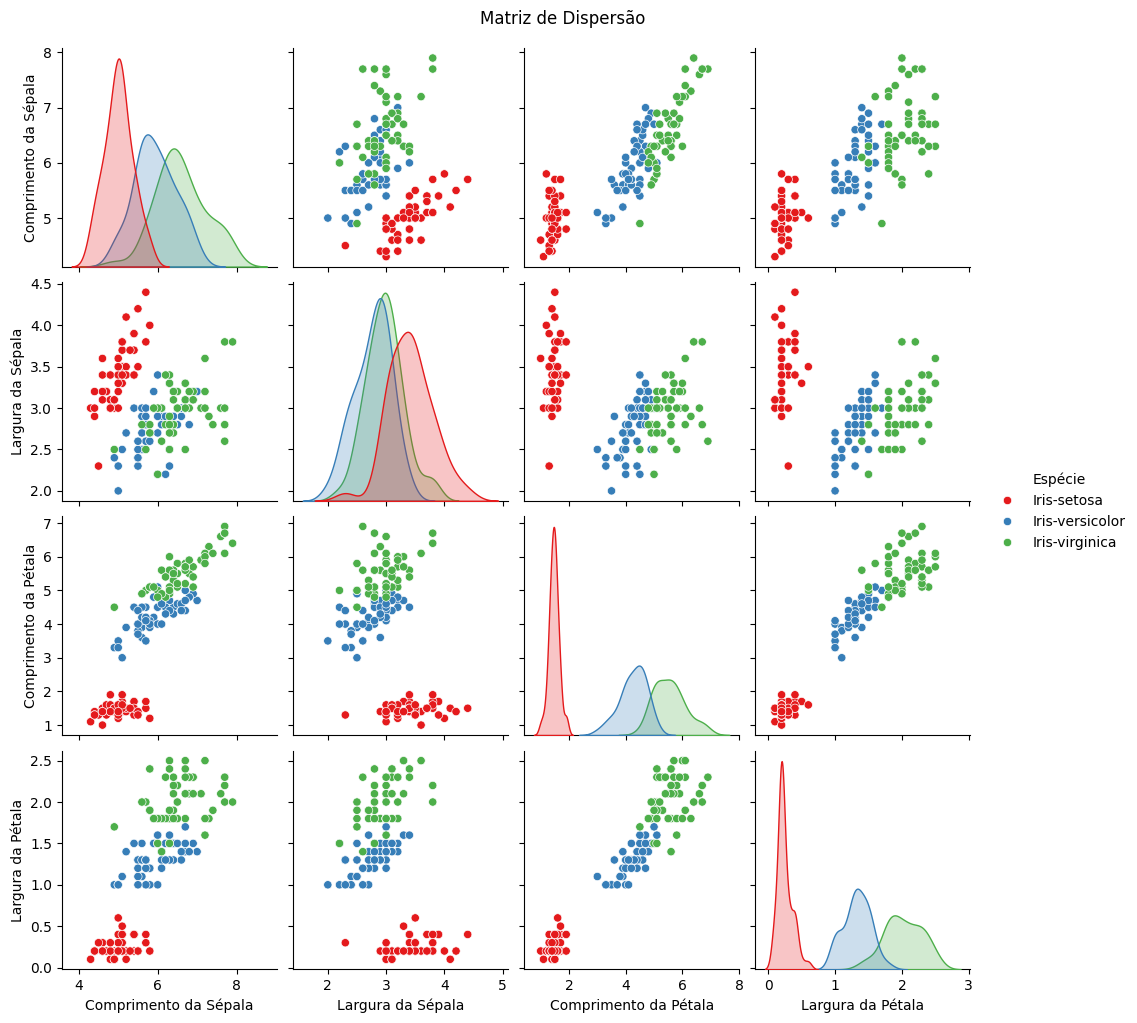

In [35]:
sns.pairplot(datasetGaussMix, hue='Espécie', palette='Set1')
plt.suptitle('Matriz de Dispersão', y=1.02)
plt.show()

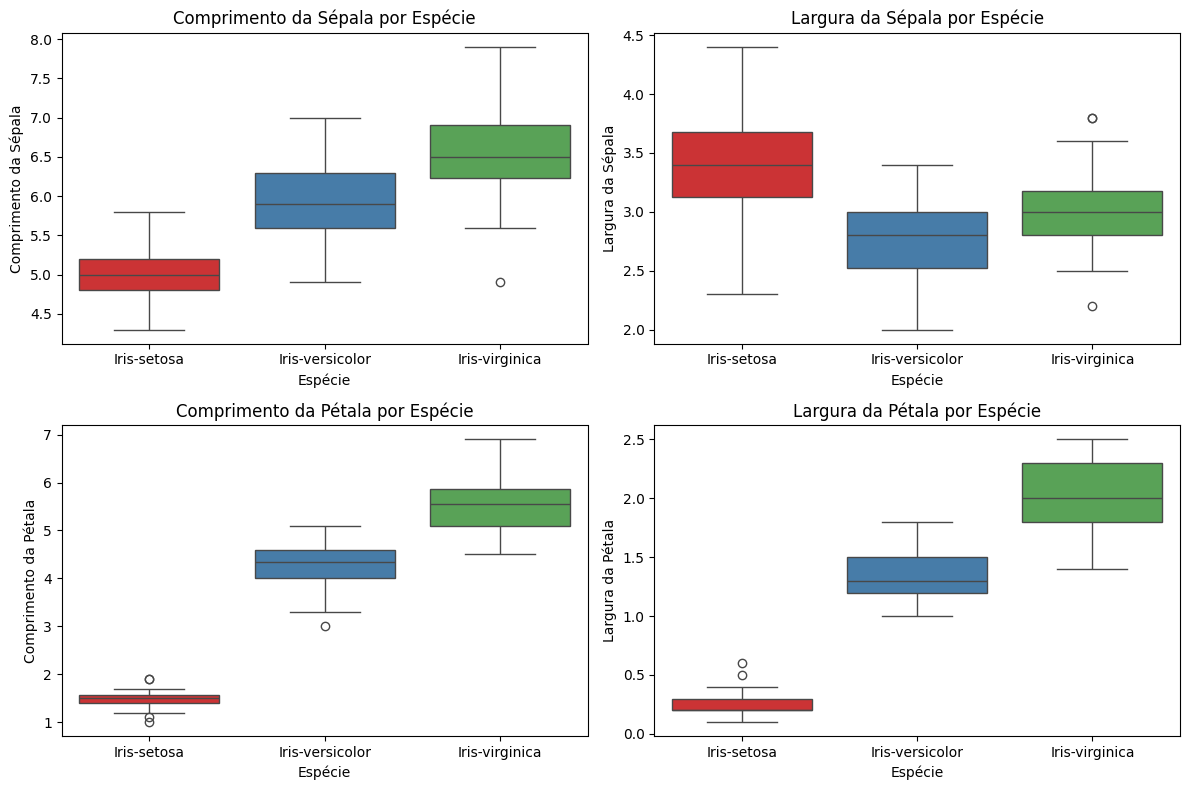

In [36]:
plt.figure(figsize=(12, 8))

for i, coluna in enumerate(datasetGaussMix.columns[:-1]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=datasetGaussMix, x='Espécie', y=coluna, hue='Espécie', palette='Set1', legend=False)
    plt.title(f'{coluna} por Espécie')

plt.tight_layout()
plt.show()

In [37]:
#FUNÇÃO PARA REMOVER OUTLIERS
def remover_outliers_por_categoria(dataset, coluna_valor, coluna_categoria):
    datasetArrumado = pd.DataFrame()

    for categoria in dataset[coluna_categoria].unique():
        grupo = dataset[dataset[coluna_categoria] == categoria]

        Q1 = grupo[coluna_valor].quantile(0.25)
        Q3 = grupo[coluna_valor].quantile(0.75)
        IQR = Q3 - Q1

        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        grupo_filtrado = grupo[(grupo[coluna_valor] >= limite_inferior) & (grupo[coluna_valor] <= limite_superior)]
        datasetArrumado = pd.concat([datasetArrumado, grupo_filtrado])

    return datasetArrumado

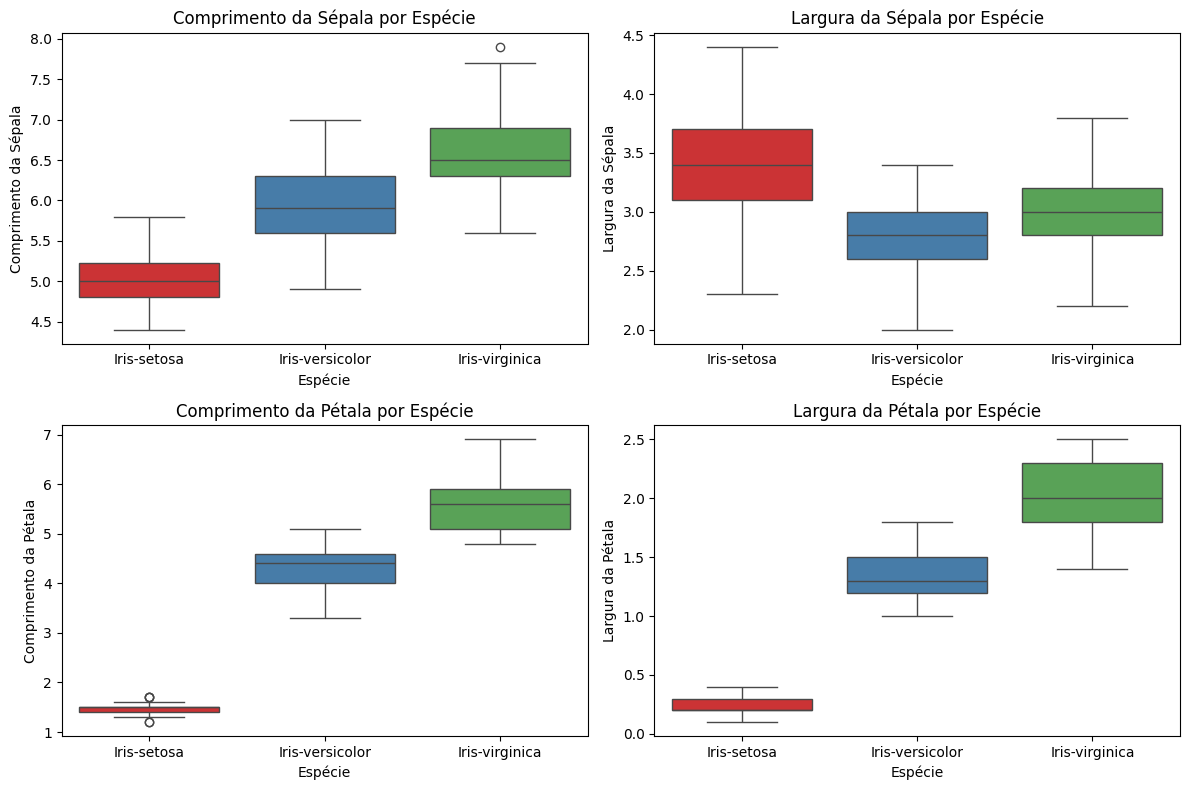

In [38]:
datasetGaussMixArrumado = datasetGaussMix.copy()

colunas = ['Comprimento da Sépala', 'Largura da Sépala',
           'Comprimento da Pétala', 'Largura da Pétala']

for coluna in colunas:
    datasetGaussMixArrumado = remover_outliers_por_categoria(datasetGaussMixArrumado, coluna, 'Espécie')

plt.figure(figsize=(12, 8))
for i, coluna in enumerate(datasetGaussMixArrumado.columns[:-1]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=datasetGaussMixArrumado, x='Espécie', y=coluna, hue='Espécie', palette='Set1', legend=False)
    plt.title(f'{coluna} por Espécie')
plt.tight_layout()
plt.show()

## **Modelo**

In [39]:
#DEFINIR VARIÁVEIS
XGaussMix = datasetGaussMixArrumado.drop(["Espécie"], axis=1)

scaler = StandardScaler()
XGaussMix_scaled = scaler.fit_transform(XGaussMix)

#TREINO DO MODELO
modelGaussMix = GaussianMixture(n_components=3, random_state=42)
modelGaussMix_labels = modelGaussMix.fit_predict(XGaussMix_scaled)

## **Extra**

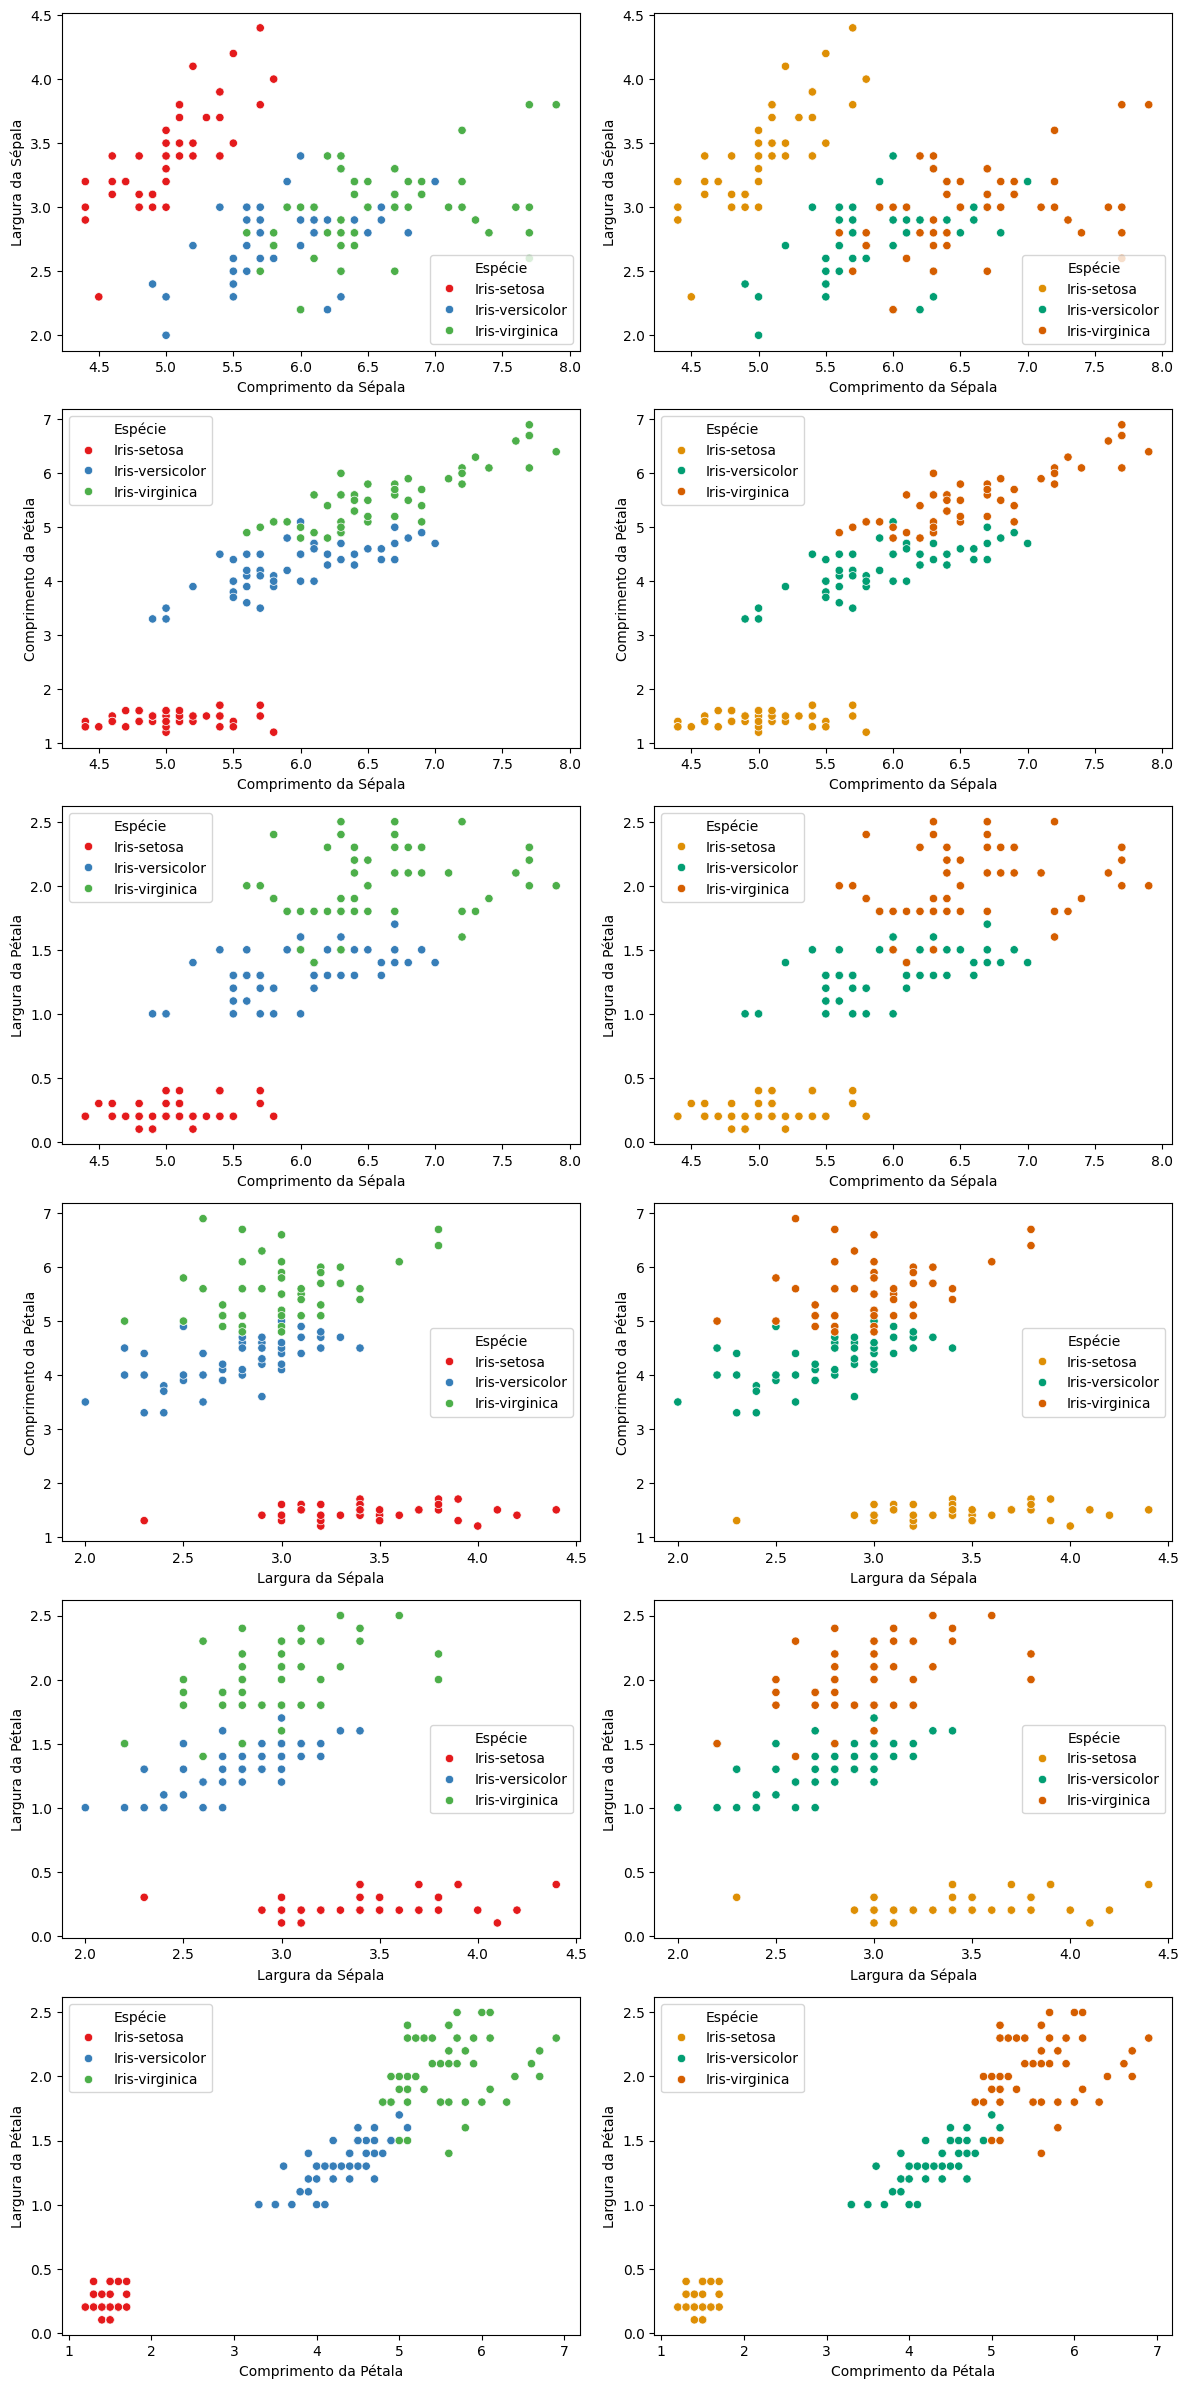

In [40]:
from itertools import combinations

features = XGaussMix.columns

YGaussMix = datasetGaussMixArrumado['Espécie']
DFGaussMix = pd.DataFrame(data=XGaussMix_scaled, columns=features)
DFGaussMix["Cluster GaussMix"] = modelGaussMix_labels
DFGaussMix["Espécie"] = YGaussMix.values

#GERA AS COMBINAÇÕES COM 2 FEATURES
combinations = list(combinations(features, 2))

plt.figure(figsize=(12, len(combinations) * 4))

for index, (x_feature, y_feature) in enumerate(combinations, 1):
    #GRÁFICO REAL
    plt.subplot(len(combinations), 2, 2 * index - 1)
    sns.scatterplot(
        x=XGaussMix[x_feature],
        y=XGaussMix[y_feature],
        hue=datasetGaussMixArrumado["Espécie"],
        palette="Set1"
    )
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)

    #GRÁFICO COM GAUSSIAN MIXTURE
    plt.subplot(len(combinations), 2, 2 * index)
    sns.scatterplot(
        x=XGaussMix[x_feature],
        y=XGaussMix[y_feature],
        hue=YGaussMix,
        palette=sns.color_palette("colorblind")[1:4]
    )
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)

plt.tight_layout()
plt.show()

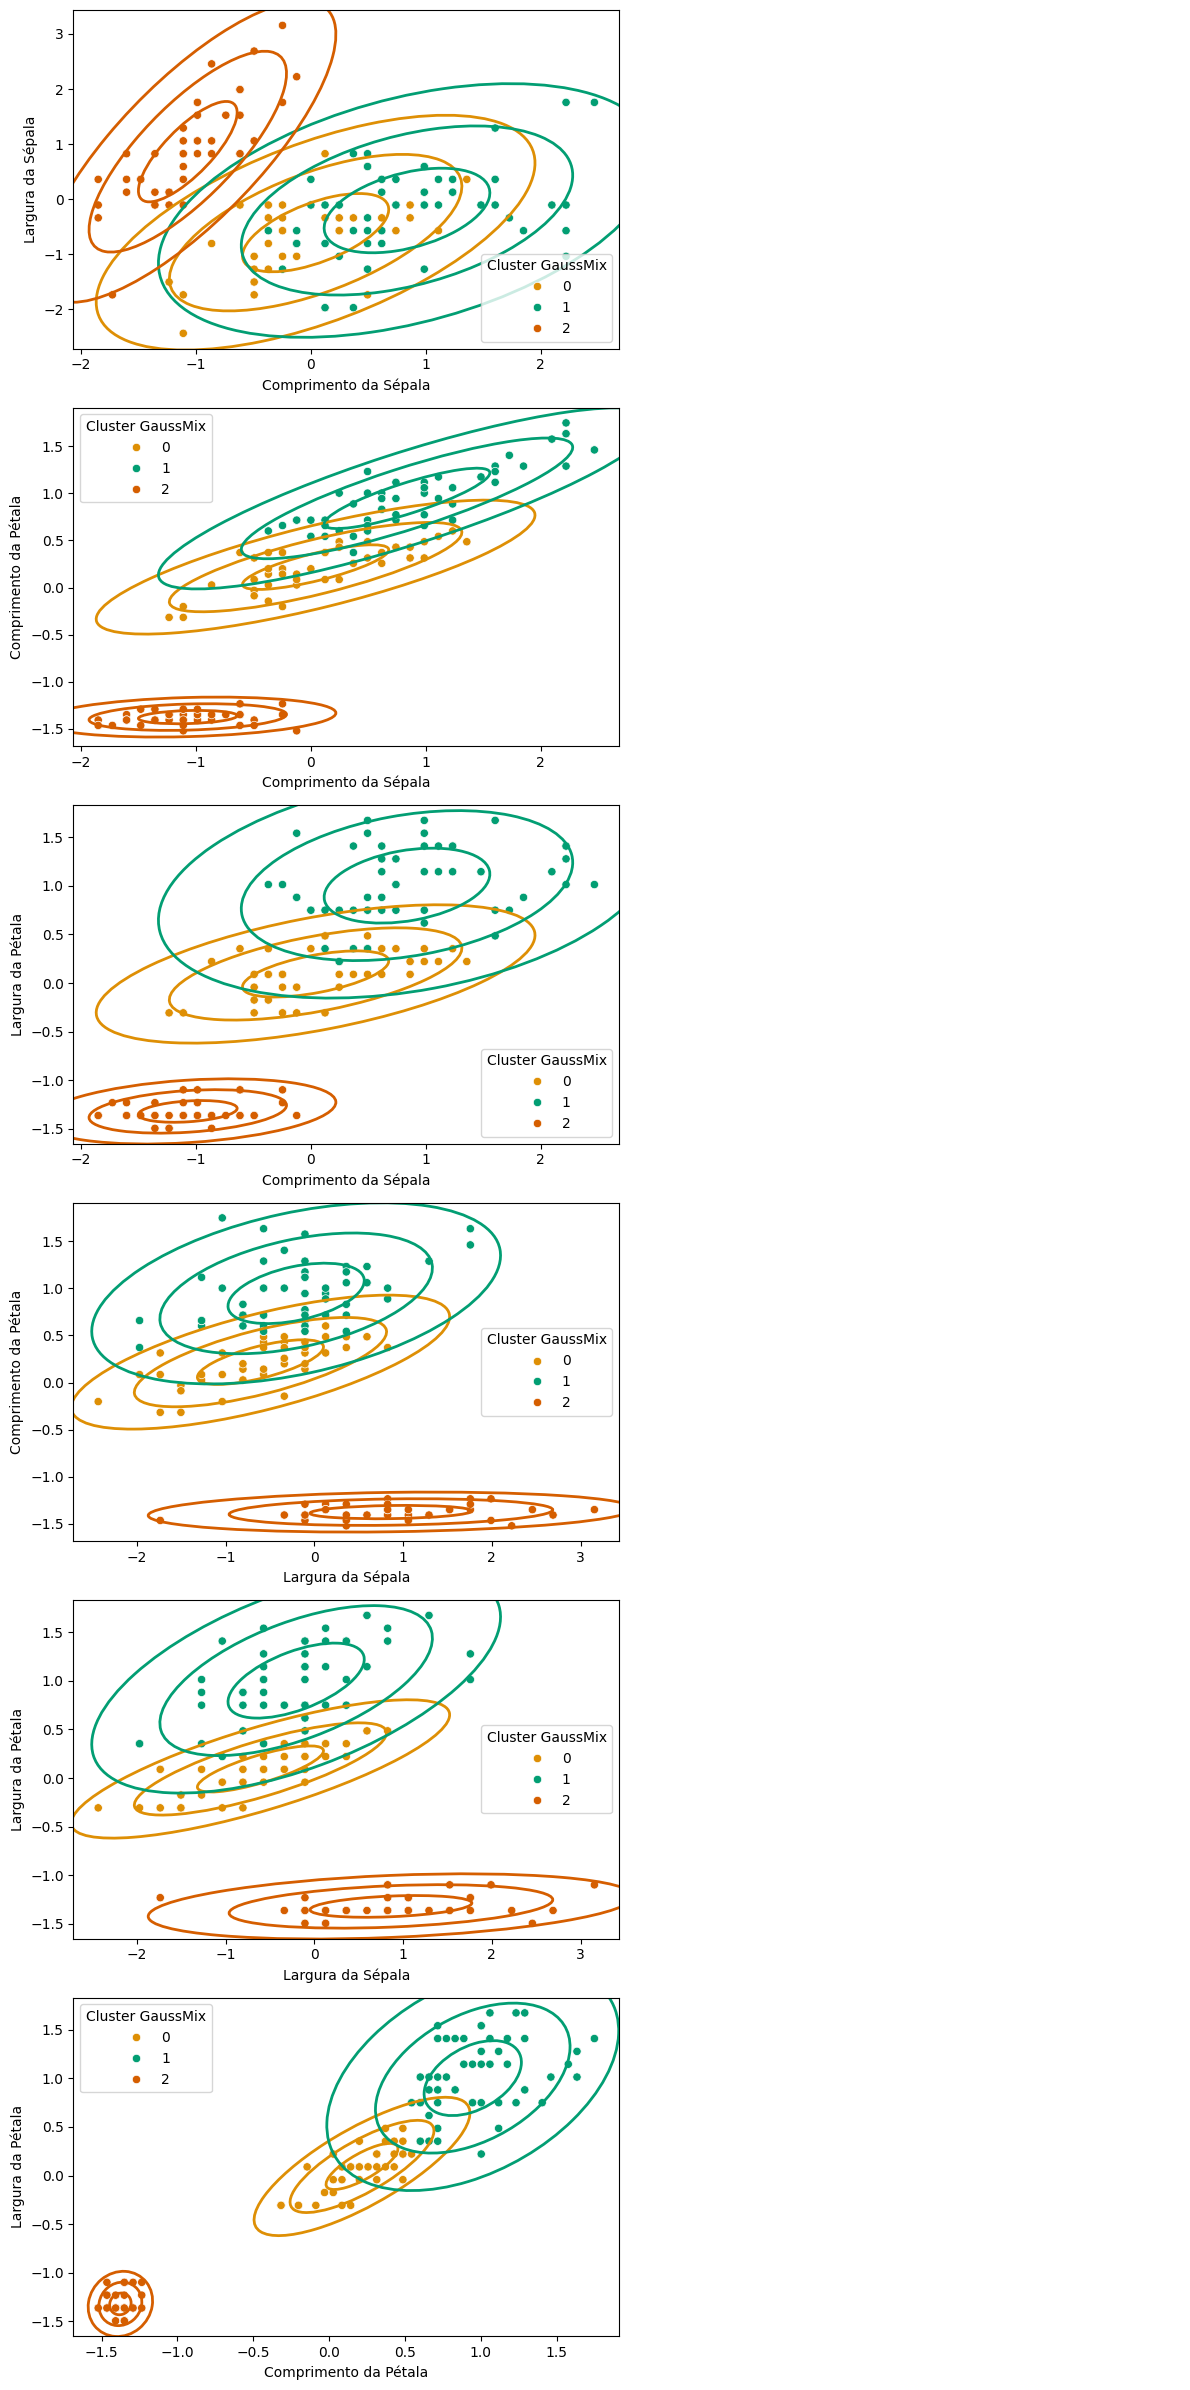

In [41]:
from matplotlib.patches import Ellipse
from itertools import combinations

#GERA AS ELIPSES
def draw_ellipse(position, covariance, ax, color):
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    for nsig in range(1, 4):
        ax.add_patch(Ellipse(
            xy=position,
            width=nsig * width,
            height=nsig * height,
            angle=angle,
            edgecolor=color,
            facecolor='none',
            linewidth=2
        ))

features = XGaussMix.columns

#GERA AS COMBINAÇÕES COM 2 FEATURES
combinations = list(combinations(features, 2))

palette = sns.color_palette("colorblind")[1:4]

plt.figure(figsize=(12, len(combinations) * 4))

for index, (x_feature, y_feature) in enumerate(combinations, 1):
    plt.subplot(len(combinations), 2, 2 * index - 1)

    sns.scatterplot(
        x=DFGaussMix[x_feature],
        y=DFGaussMix[y_feature],
        hue=DFGaussMix["Cluster GaussMix"],
        palette=palette
    )
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)

    for i, (mean, covar) in enumerate(zip(modelGaussMix.means_, modelGaussMix.covariances_)):
        idx1, idx2 = features.get_loc(x_feature), features.get_loc(y_feature)
        mean_2d = mean[[idx1, idx2]]
        covar_2d = covar[np.ix_([idx1, idx2], [idx1, idx2])]
        draw_ellipse(mean_2d, covar_2d, plt.gca(), color=palette[i])

    plt.subplot(len(combinations), 2, 2 * index)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [43]:
df_amostras = pd.concat([DFGaussMix.reset_index(drop=True), df_probabilidades], axis=1)

#SELECIONA 3 AMOSTRAS ALEATÓRIAS DE CADA CLUSTER
amostras_por_cluster = (
    df_amostras.groupby("Cluster GaussMix")
    .apply(lambda x: x.sample(n=3, random_state=42))
    .reset_index(drop=True)
)

display(amostras_por_cluster)

<ipython-input-43-0e8b22de54be>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=3, random_state=42))


,Comprimento da Sépala,Largura da Sépala,Comprimento da Pétala,Largura da Pétala,Cluster GaussMix,Espécie,Prob_Cluster_0,Prob_Cluster_1,Prob_Cluster_2
0,-0.12,-1.04,0.08,-0.04,0,Iris-versicolor,1.00,0.00,0.00
1,0.12,-0.34,0.37,0.35,0,Iris-versicolor,0.97,0.03,0.00
2,-0.24,-1.04,-0.20,-0.31,0,Iris-versicolor,1.00,0.00,0.00
3,0.62,0.36,0.83,1.41,1,Iris-virginica,0.00,1.00,0.00
4,0.99,-0.11,0.77,1.41,1,Iris-virginica,0.00,1.00,0.00
5,0.99,0.59,1.06,1.67,1,Iris-virginica,0.00,1.00,0.00
6,-1.72,-1.74,-1.47,-1.23,2,Iris-setosa,0.00,0.00,1.00
7,-0.86,0.83,-1.41,-1.36,2,Iris-setosa,0.00,0.00,1.00
8,-1.48,0.36,-1.29,-1.36,2,Iris-setosa,0.00,0.00,1.00
